# Homework 1: Futures Spread Data Characterization
---
#### Philip Lee
#### ID: 12129240

# 1 Introduction

Here we will practice obtaining data for spreads in futures markets, and characterizing their dynamics.

# 2 Data

Obtain second month quarterly 1 futures prices from the Quandl OWF database for two pair W, X; Y, Z (where W, X and Y and Z depend on your student ID number) for 3 Dec 2019 though 31 Aug 2021. Our defi- nition of second month is the contact where the number of days to futures expiration is the smallest available value greater than 30.

Form the spreads s(1), s(2) between these numbers as the difference s(1) = X − W and s(2) = Z − Y .

In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:.4f}".format
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,10)
# plt.style.use("~/.dracula.mplstyle") 
import requests
import quandl
import functools
import re
import statsmodels.api as sm

# QUANDL Config
import os, sys
parent_path = os.path.abspath(os.path.join('..'))
if parent_path not in sys.path:
    sys.path.append(parent_path)
from common.config import QUANDL_API_KEY  # If you are not Philip, you don't have config
                                          # unless you use your own API key

quandl.ApiConfig.api_key = QUANDL_API_KEY # Replace with your API key if running.

## Set up `GLOBAL` variables

`GLOBAL` variables will be used throughout the notebook and remain unchanged.

In [2]:
START_DATE = "2019-12-03"
END_DATE   = "2021-08-31"

DB         = "OWF/"
ASSETS     = ["CBT_FV_FV", "CBT_TU_TU", "ICE_B_B", "ICE_G_G"]
QUARTERS   = ['H', 'M', 'U', 'Z']
YEARS      = [str(yyyy) for yyyy in range(int(START_DATE[:4]),
                                          int(END_DATE[:4])+1)] # if anything fails its here
YEARS      = ["2020", "2021"]
SUFFIX     = "_IVM"

pull       = [DB+a+'_'+q+y+SUFFIX for y in YEARS
                                  for q in QUARTERS
                                  for a in ASSETS]
display(pull[:4])

['OWF/CBT_FV_FV_H2020_IVM',
 'OWF/CBT_TU_TU_H2020_IVM',
 'OWF/ICE_B_B_H2020_IVM',
 'OWF/ICE_G_G_H2020_IVM']

## Wrap Quandl in cached decorator

To prevent unnecessary API calls that waste valuable time.

As we can see, the raw data is quite unfriendly with Column names including both the asset name and measure.

In [3]:
if "pull_quandl" in globals():
    print("Not re-defining.")
else:
    print("Defining quandl pull")
    @functools.lru_cache(maxsize=16)
    def pull_quandl(pull, start_date, end_date):
        ret = quandl.get(list(pull), start_date=start_date, end_date=end_date)
        return ret

owf_raw = pull_quandl(tuple(pull), START_DATE, END_DATE)
display(owf_raw.head())

Defining quandl pull


,OWF/CBT_FV_FV_H2020_IVM - Future,OWF/CBT_FV_FV_H2020_IVM - AtM,OWF/CBT_FV_FV_H2020_IVM - RR25,OWF/CBT_FV_FV_H2020_IVM - RR10,OWF/CBT_FV_FV_H2020_IVM - Fly25,OWF/CBT_FV_FV_H2020_IVM - Fly10,OWF/CBT_FV_FV_H2020_IVM - Beta1,OWF/CBT_FV_FV_H2020_IVM - Beta2,OWF/CBT_FV_FV_H2020_IVM - Beta3,OWF/CBT_FV_FV_H2020_IVM - Beta4,...,OWF/ICE_G_G_Z2021_IVM - Beta1,OWF/ICE_G_G_Z2021_IVM - Beta2,OWF/ICE_G_G_Z2021_IVM - Beta3,OWF/ICE_G_G_Z2021_IVM - Beta4,OWF/ICE_G_G_Z2021_IVM - Beta5,OWF/ICE_G_G_Z2021_IVM - Beta6,OWF/ICE_G_G_Z2021_IVM - MinMoney,OWF/ICE_G_G_Z2021_IVM - MaxMoney,OWF/ICE_G_G_Z2021_IVM - DtE,OWF/ICE_G_G_Z2021_IVM - DtT
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-03,119.3672,0.0274,0.0005,0.0017,0.0004,0.0019,0.0224,4.5335,76.6694,5394.3322,...,-0.0209,-0.2711,1.4202,9.4362,-59.9190,83.4223,-0.1374,0.2537,730.8500,738.0000
2019-12-04,118.9922,0.0265,0.0005,0.0012,0.0006,0.0025,0.0292,7.8833,-0.4661,1046.9718,...,-0.0167,-0.2247,0.5764,8.9464,-18.1752,-38.2658,-0.1526,0.2385,729.8500,737.0000
2019-12-05,118.9219,0.0270,0.0006,0.0013,0.0005,0.0023,0.0349,6.4356,-15.9653,4287.8200,...,-0.0179,-0.2153,0.6176,8.2396,-17.5342,-34.6087,-0.1549,0.2363,728.8500,736.0000
2019-12-06,118.6641,0.0266,0.0009,0.0018,0.0009,0.0034,0.0500,12.5606,-26.6452,-7024.1396,...,-0.0174,-0.2521,0.4546,10.0946,-12.2060,-70.5269,-0.1572,0.2340,727.8500,735.0000
2019-12-09,118.6797,0.0266,0.0014,0.0027,0.0010,0.0038,0.0826,15.3082,-73.0926,-12297.5427,...,-0.0175,-0.2418,0.5082,9.5430,-15.0781,-54.4704,-0.1558,0.2354,724.8500,732.0000


In [4]:
def clean_columns(s: str, pre=len(DB)):
    """Takes in Quandl formatted column names...
    returns a list to construct a pd.MultiIndex
    "OWF/CBT_FV_FV_H2020_IVM - Future" -> ['CBT_FV_FV', 'H2020', 'Future']
    """
    ret = re.split(r"([A-Z]\d{4})|( - )", s[pre:])
    return [ret[0][:-1], ret[1], ret[-1]]

test_col = owf_raw.columns[0]
print(f"IN:\n{test_col}\nOUT:\n{clean_columns(test_col)}")

IN:
OWF/CBT_FV_FV_H2020_IVM - Future
OUT:
['CBT_FV_FV', 'H2020', 'Future']


## Create MultiIndex

MultiIndex includes `ASSET`, `EXP` (expiration quarter), and `MEASURE`. This construction enables the efficient slicing of different columns on the fly without manually creating extra DataFrames.

In [5]:
owf_clean = owf_raw.copy(deep=True)
owf_clean.columns = pd.MultiIndex.from_arrays(
    np.array([clean_columns(c) for c in owf_clean.columns]).T,
    names=("ASSET", "EXP", "MEASURE"))

display(owf_clean.head())

ASSET      CBT_FV_FV                                                    \
EXP            H2020                                                     
MEASURE       Future    AtM   RR25   RR10  Fly25  Fly10  Beta1   Beta2   
Date                                                                     
2019-12-03  119.3672 0.0274 0.0005 0.0017 0.0004 0.0019 0.0224  4.5335   
2019-12-04  118.9922 0.0265 0.0005 0.0012 0.0006 0.0025 0.0292  7.8833   
2019-12-05  118.9219 0.0270 0.0006 0.0013 0.0005 0.0023 0.0349  6.4356   
2019-12-06  118.6641 0.0266 0.0009 0.0018 0.0009 0.0034 0.0500 12.5606   
2019-12-09  118.6797 0.0266 0.0014 0.0027 0.0010 0.0038 0.0826 15.3082   

ASSET                            ... ICE_G_G                                  \
EXP                              ...   Z2021                                   
MEASURE       Beta3       Beta4  ...   Beta1   Beta2  Beta3   Beta4    Beta5   
Date                             ...                                           
2019-12-03  76.6694   5394.3322  ... -0.0209 -0.2711 1.4202  9.4362 -59.9190   
2019-12-04  -0.4661   1046.9718  ... -0.0167 -0.2247 0.5764  8.9464 -18.1752   
2019-12-05 -15.9653   4287.8200  ... -0.0179 -0.2153 0.6176  8.2396 -17.5342   
2019-12-06 -26.6452  -7024.1396  ... -0.0174 -0.2521 0.4546 10.0946 -12.2060   
2019-12-09 -73.0926 -12297.5427  ... -0.0175 -0.2418 0.5082  9.5430 -15.0781   

ASSET                                                    
EXP                                                      
MEASURE       Beta6 MinMoney MaxMoney      DtE      DtT  
Date                                                     
2019-12-03  83.4223  -0.1374   0.2537 730.8500 738.0000  
2019-12-04 -38.2658  -0.1526   0.2385 729.8500 737.0000  
2019-12-05 -34.6087  -0.1549   0.2363 728.8500 736.0000  
2019-12-06 -70.5269  -0.1572   0.2340 727.8500 735.0000  
2019-12-09 -54.4704  -0.1558   0.2354 724.8500 732.0000  

[5 rows x 512 columns]

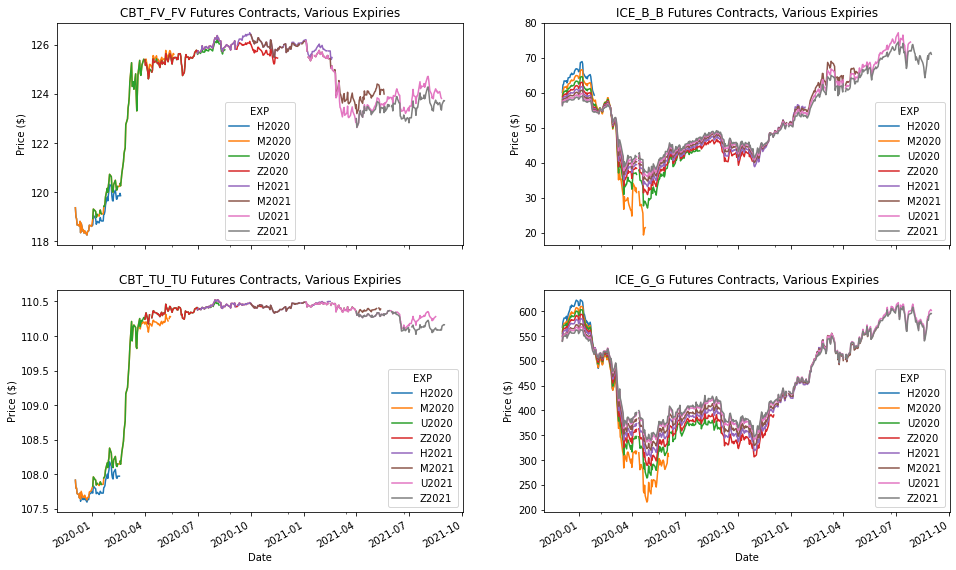

In [6]:
pairs = len(ASSETS)//2

fig, axs = plt.subplots(2,pairs, sharex=True)

for i, a in enumerate(ASSETS):
    to_plot = owf_clean[a]
    to_plot.swaplevel(0,1,axis=1)["Future"].plot(ax=axs[i%2,i//2])
    axs[i%2,i//2].set_title(f"{a} Futures Contracts, Various Expiries")
    axs[i%2,i//2].set_ylabel("Price ($)")

plt.show()

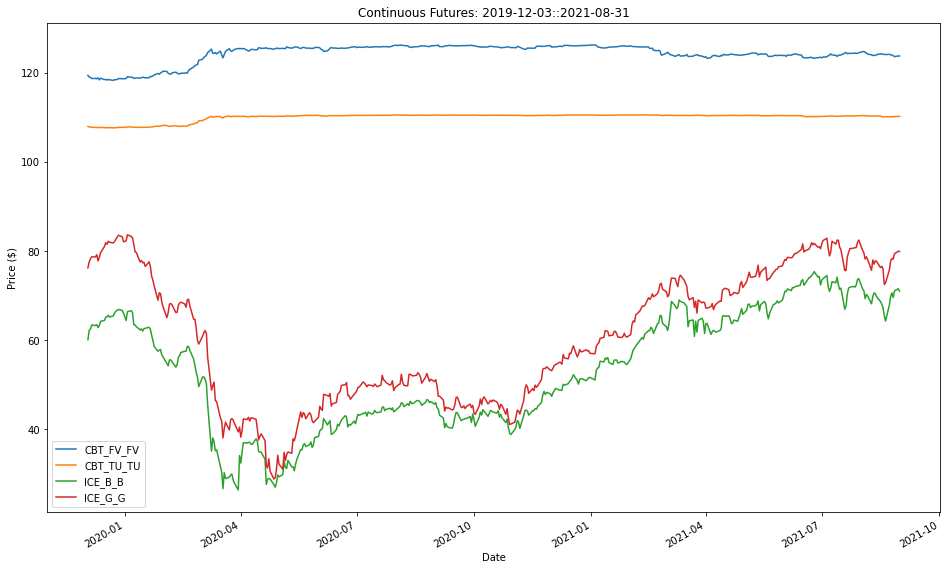

In [7]:
def qtrly_to_cont(df, thresh=30):
    """Quarterly Expiry Futures to Continuous
    df: pd.DataFrame of cleaned Quandl Data. "DtT"=date to termination; "Future"=futures price.
    thresh: int denoting how many days until expiry to roll over to next expiry
    """
    # First make sure there are no NaN values in the time series. Use forward fill on NaN
    expiries  = df.swaplevel(0,1,axis=1)["DtT"].interpolate(method="linear", limit_area="inside")
    prices    = df.swaplevel(0,1,axis=1)["Future"].fillna(method="ffill")
    mins      = expiries[expiries>thresh].idxmin(axis=1)
    indicator = pd.get_dummies(mins)[expiries.columns] # a DF with 1 if closest to exp
    ret       = (indicator * prices).sum(axis=1)
    #                      ^ elem mul  ^ get quarterly prices
    return ret

cont = []
for a in ASSETS:
    cont.append(qtrly_to_cont(owf_clean[a]))

cont_fut = pd.concat(cont, axis=1, keys=ASSETS)
cont_fut["ICE_G_G"] /= 7.45
cont_fut.plot()
plt.title(f"Continuous Futures: {START_DATE}::{END_DATE}")
plt.ylabel("Price ($)")
plt.show()

## ICE NaN values that were filled
ICE does not trade on Christmas or Good Friday. To retain as much data as we can, I forward filled the NaN values (uses the last valid observation to fill the gap).

In [8]:
owf_clean.loc[["2020-04-10", "2020-12-25", "2021-04-02"],:].swaplevel(1,2,1)["ICE_B_B"]["DtT"]

EXP,H2020,M2020,U2020,Z2020,H2021,M2021,U2021,Z2021
Date,,,,,,,,
2020-04-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Sanity Check

Against provided spreads in Section 3.1

In [9]:
spreads = pd.concat([cont_fut[ASSETS[i+1]] - cont_fut[ASSETS[i]] for i in range(0,len(ASSETS),2)],
                    axis=1, keys = [f"{ASSETS[i+1]}-{ASSETS[i]}" for i in range(0,len(ASSETS),2)])

display(pd.DataFrame(
    {"Actual": [spreads.loc["2021-02-18", "CBT_TU_TU-CBT_FV_FV"],
                spreads.loc["2021-02-19", "CBT_TU_TU-CBT_FV_FV"],
                spreads.loc["2021-02-08", "ICE_G_G-ICE_B_B"],
                spreads.loc["2021-02-09", "ICE_G_G-ICE_B_B"]],
     "Expected": [-15.000000, -14.496875, 6.606510, 6.719866]}))

,Actual,Expected
0,-15.0000,-15.0000
1,-14.4969,-14.4969
2,6.6065,6.6065
3,6.7199,6.7199


# 3 Analysis
Characterize the relative dynamics of s(i) in reasonable ways, using charts t
and statistics.

For example, compute the median and standard deviation of the difference
d(N) between s(i) and an N-day rolling average of s for some values of N.

Examine more quantiles than just the median. Look at tails. Do the spreads correlate? How about their difference (d) values? Do spreads exhibit patterns over time?

median std
moving averages


N day difference 

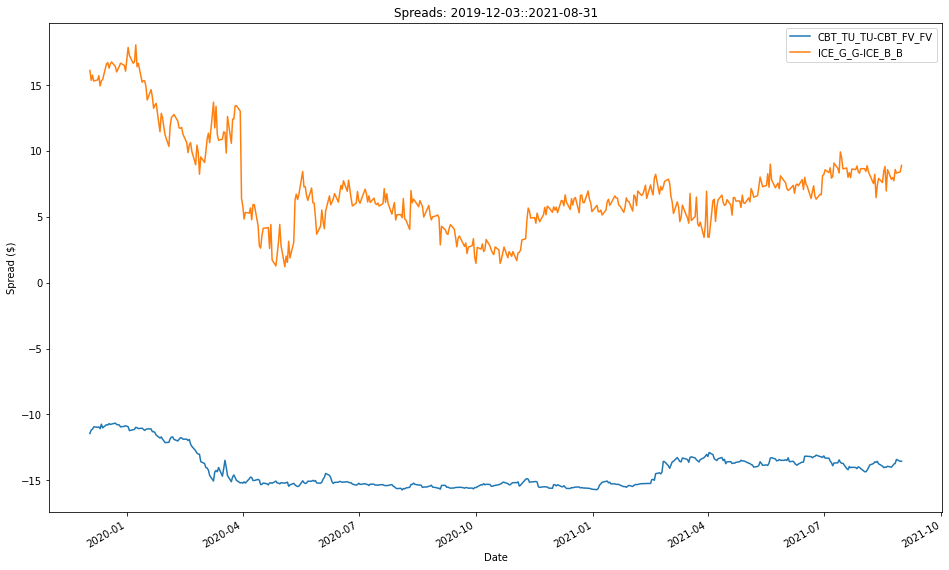

In [10]:
spreads.plot()
plt.title(f"Spreads: {START_DATE}::{END_DATE}")
plt.ylabel("Spread ($)")
plt.show()

## Spread Level Dynamics

From an examination of charts, the spreads tend to have periods of movement followed by periods of relative stability. The CBT TU-FV spread started decreasing in February 2020; stabilized from March 2020-February 2021; increased from February 2021-March 2021; and stabilized from March 2021-August 2021. The CBT TU-FV spread frequency distribution shows 3 clusters centered around $[-15.50, -13.75, -11.50]$ The ICE G-B spread decreased from December 2019-April 2020 and stabilized from April 2020-August 2021. The ICE G-B spread frequency distribution shows 1 cluster around $6.50$.

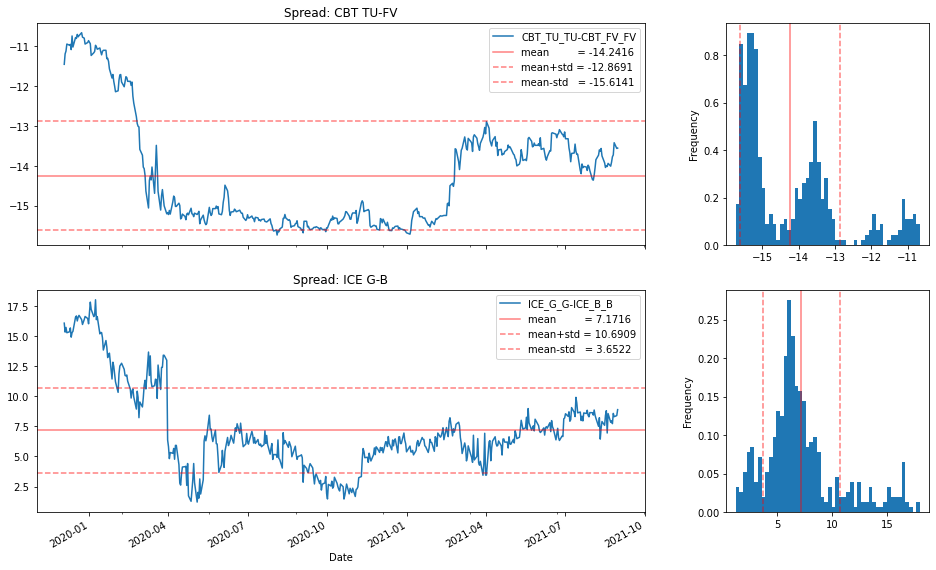

In [11]:
def plot_ts_hist(ts, ax):
    """Plot the time-series and show a histogram.
    ts: pd.Series or pd.DataFrame with 1 column
    ax: plt axis of length 2
    """
    ts.plot(ax=ax[0])
    tsm = ts.mean()
    tss = ts.std()
    ax[0].axhline(tsm    , c='r', alpha=0.5, label=f"mean         = {tsm:.4f}")
    ax[0].axhline(tsm+tss, c='r', alpha=0.5, label=f"mean+std = {tsm+tss:.4f}", linestyle="--")
    ax[0].axhline(tsm-tss, c='r', alpha=0.5, label=f"mean-std   = {tsm-tss:.4f}", linestyle="--")
    ax[0].legend()
    ts.plot.hist(bins=50, ax=ax[1], density=True)
    ax[1].axvline(tsm    , c='r', alpha=0.5)
    ax[1].axvline(tsm+tss, c='r', alpha=0.5, linestyle="--")
    ax[1].axvline(tsm-tss, c='r', alpha=0.5, linestyle="--")

fig, axs = plt.subplots(2,2, gridspec_kw={"width_ratios":[3,1]})
axs[1,0].sharex(axs[0,0])

plot_ts_hist(spreads["CBT_TU_TU-CBT_FV_FV"], axs[0])
axs[0,0].set_title(f"Spread: CBT TU-FV")
plot_ts_hist(spreads["ICE_G_G-ICE_B_B"], axs[1])
axs[1,0].set_title(f"Spread: ICE G-B")

plt.show()

## Spread Return Dynamics

The log returns of spreads appear to be relatively normally distributed wiht a slight negative skew. The CBT TU-FV spread returns are centered around $0.0004$ and have a daily standard deviation of $0.0116$. The ICE G-B spread returns are centered around $-0.0013$ and have a daily standard deviation of $0.1785$. The spread returns have such a drastic difference in standard deviation because the CBT TU-FV spread maintains a higher level (therefore exhibiting smaller returns) and the ICE G-B spread has levels close to 0 (therefore having large returns).

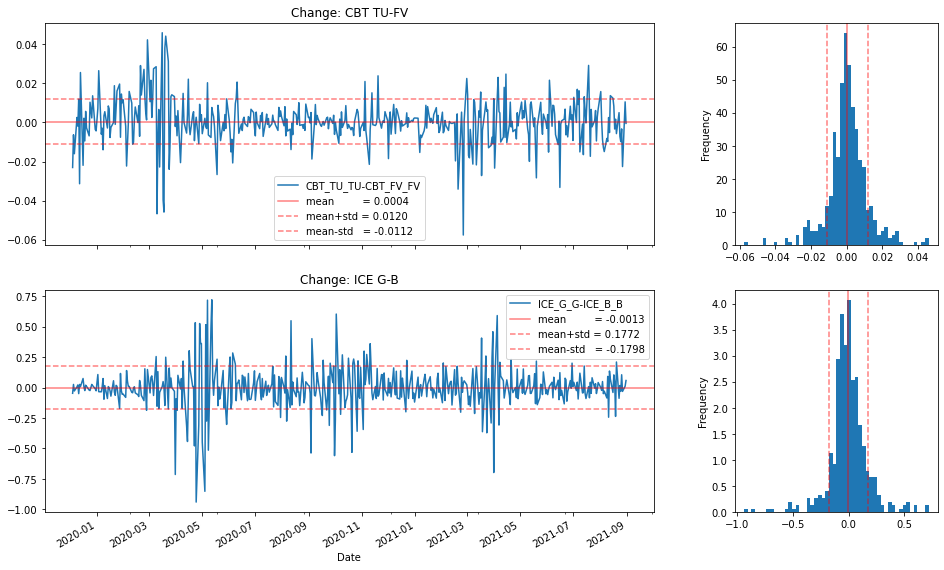

In [12]:
changes = np.log(spreads / spreads.shift(1))

fig, axs = plt.subplots(2,2, gridspec_kw={"width_ratios":[3,1]})
axs[1,0].sharex(axs[0,0])

plot_ts_hist(changes["CBT_TU_TU-CBT_FV_FV"], axs[0])
axs[0,0].set_title(f"Change: CBT TU-FV")
plot_ts_hist(changes["ICE_G_G-ICE_B_B"], axs[1])
axs[1,0].set_title(f"Change: ICE G-B")

plt.show()

## Spread Difference Dynamics

In analyzing spread moving averages, I chose $[5, 10, 20, 65]$ day ($[1,2,4,13]$ week) windows. All moving averages aside from the 65 day tend to track the level of the spread closely. The differences in the spreads tend to be centered around 0 with continued periods of divergence.

The shorter term differences for both asset pairs tended to be normally distributed. As the moving average window increases, the distribution appears less normal.

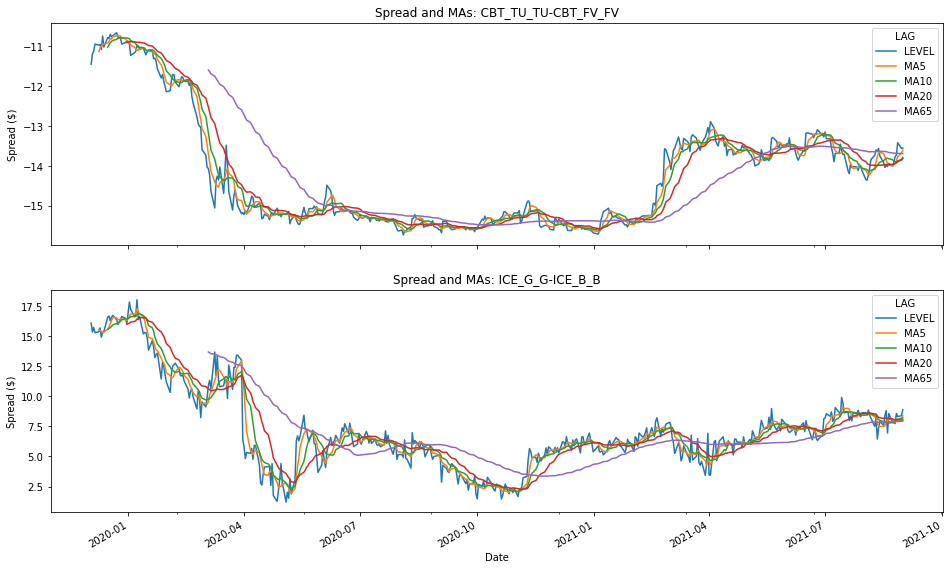

In [13]:
spreads_cols = spreads.columns.copy(deep=True)
lags = [5,10,20,65]
mas  = [f"MA{n}" for n in lags]

spread_ma = [spreads] + [spreads.rolling(n).mean() for n in lags]
spread_ma = pd.concat(spread_ma, axis=1)
spread_ma.columns = pd.MultiIndex.from_arrays(
    np.array([[l, c] for l in ["LEVEL"]+mas
                     for c in spreads_cols]).T,
    names=["LAG", "ASSET"]
)

fig, axs = plt.subplots(len(spreads_cols), sharex=True)

for i, c in enumerate(spreads_cols):
    spread_ma.swaplevel(0,1,1)[c].plot(ax=axs[i])
    axs[i].set_title(f"Spread and MAs: {c}")
    axs[i].set_ylabel("Spread ($)")

plt.show()

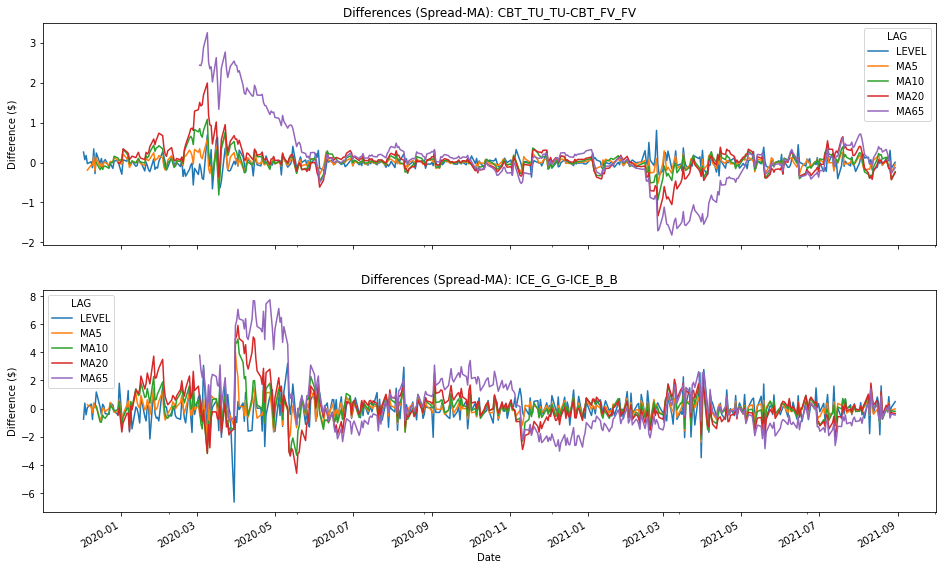

In [14]:
diff_ma = spread_ma.shift(-1).subtract(spread_ma["LEVEL"], axis=1)
                #  ^ so the MA does not incorporate today's info

fig, axs = plt.subplots(len(spreads_cols), sharex=True)

for i, c in enumerate(spreads_cols):
    diff_ma.swaplevel(0,1,1)[c].plot(ax=axs[i])
    axs[i].set_title(f"Differences (Spread-MA): {c}")
    axs[i].set_ylabel("Difference ($)")

plt.show()

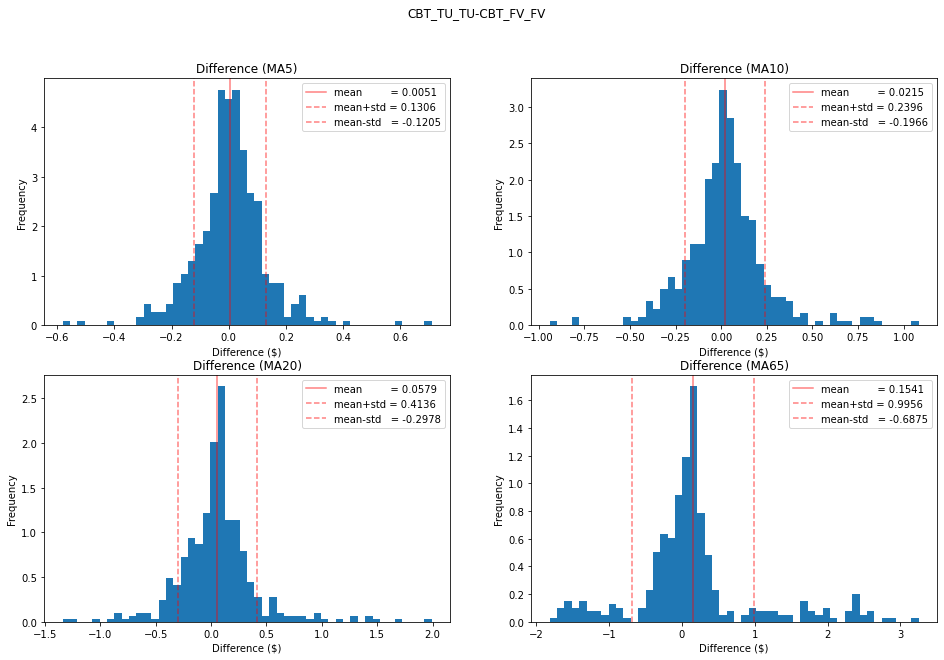

In [15]:
def plot_hist(df, ma, plot_spread, ax):
    """Plot a histogram with mean, and 1 standard deviation.
    df: pd.DataFrame of moving averages with multiindex
    ma: level of multiindex (MA{days})
    plot_spread: level of multiindex (asset pair)
    ax: plt axis
    """
    ts = df[ma][plot_spread]
    ax.hist(ts, bins=50, density=True)
    ax.set_title(f"Difference ({ma})")
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Difference ($)")
    tsm = ts.mean()
    tss = ts.std()
    ax.axvline(tsm    , c='r', alpha=0.5, label=f"mean         = {tsm:.4f}")
    ax.axvline(tsm+tss, c='r', alpha=0.5, label=f"mean+std = {tsm+tss:.4f}", linestyle="--")
    ax.axvline(tsm-tss, c='r', alpha=0.5, label=f"mean-std   = {tsm-tss:.4f}", linestyle="--")
    ax.legend()

fig, axs = plt.subplots(2,2)
plot_spread = spreads_cols[0]

for i, ma in enumerate(diff_ma.columns.unique(level="LAG")[1:]):
    plot_hist(diff_ma, ma, plot_spread, axs[i//2,i%2])

plt.suptitle(plot_spread)
plt.show()

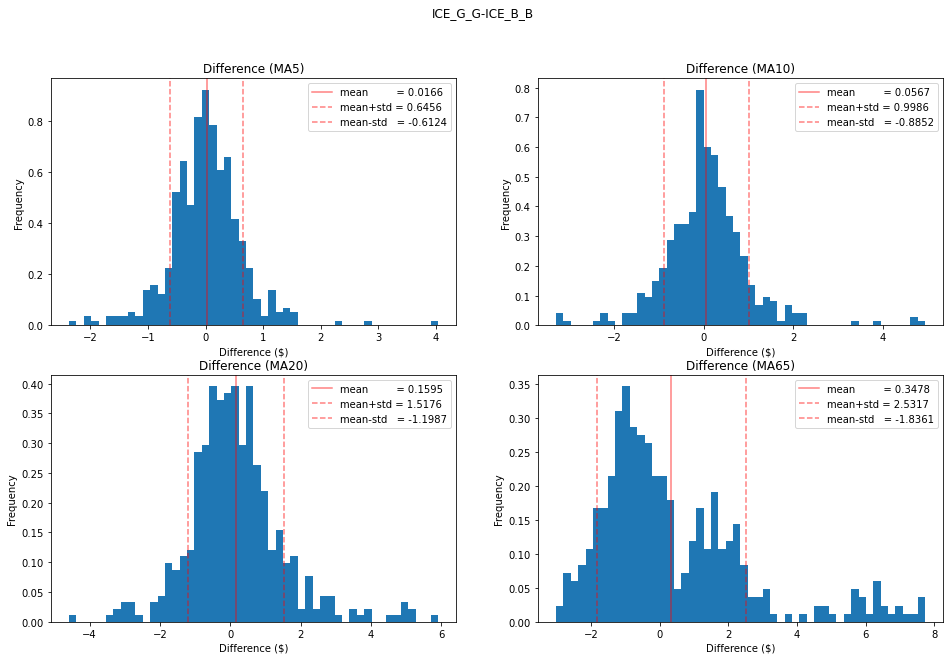

In [16]:
fig, axs = plt.subplots(2,2)
plot_spread = spreads_cols[1]

for i, ma in enumerate(diff_ma.columns.unique(level="LAG")[1:]):
    plot_hist(diff_ma, ma, plot_spread, axs[i//2,i%2])

plt.suptitle(plot_spread)
plt.show()

## Spread Correlation

Autocorrelation of the spread changes and the difference changes appear spurious and insignificant. Various datapoints appear above the Statsmodels package's threshold, yet they exhibit no recognizable pattern, so we may not draw conclusions from them.

(Hidden) the correlation of levels between the two asset pair spreads also appears to be weak.

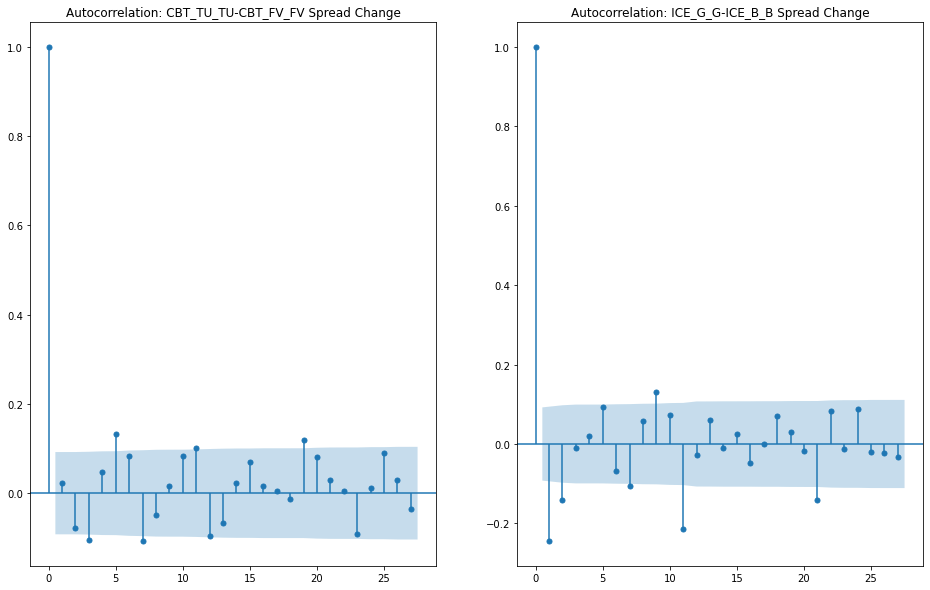

In [17]:
fig, axs = plt.subplots(1,2)

for i, s in enumerate(spreads_cols):
    sm.graphics.tsa.plot_acf(changes[s].dropna(), ax=axs[i])
    axs[i].set_title(f"Autocorrelation: {s} Spread Change")

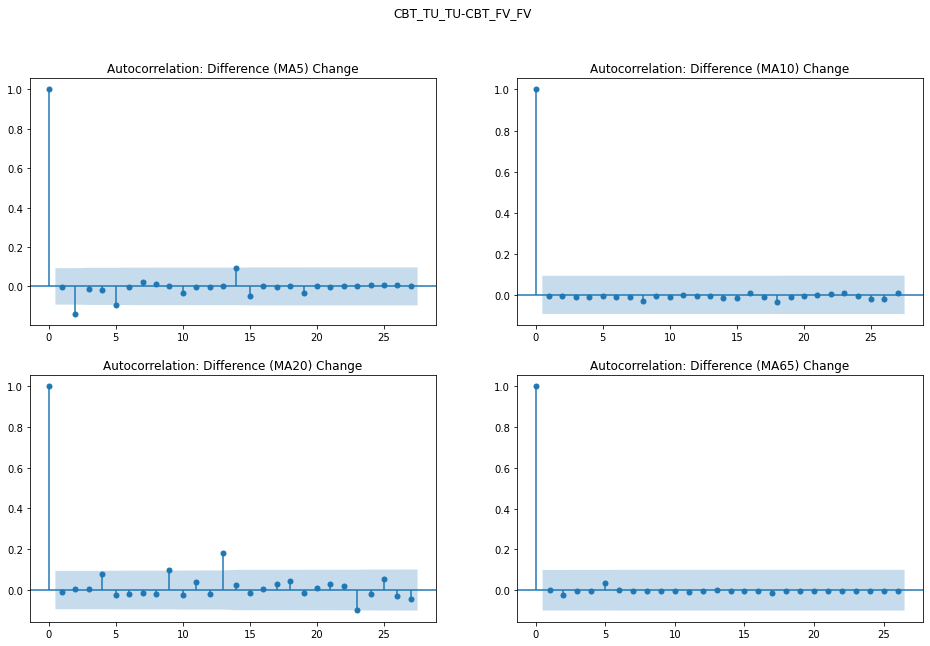

In [18]:
fig, axs = plt.subplots(2,2)
plot_spread = spreads_cols[0]

for i, ma in enumerate(diff_ma.columns.unique(level="LAG")[1:]):
    sm.graphics.tsa.plot_acf(diff_ma[ma][plot_spread].pct_change().dropna(), ax=axs[i//2,i%2])
    axs[i//2,i%2].set_title(f"Autocorrelation: Difference ({ma}) Change")

plt.suptitle(plot_spread)
plt.show()

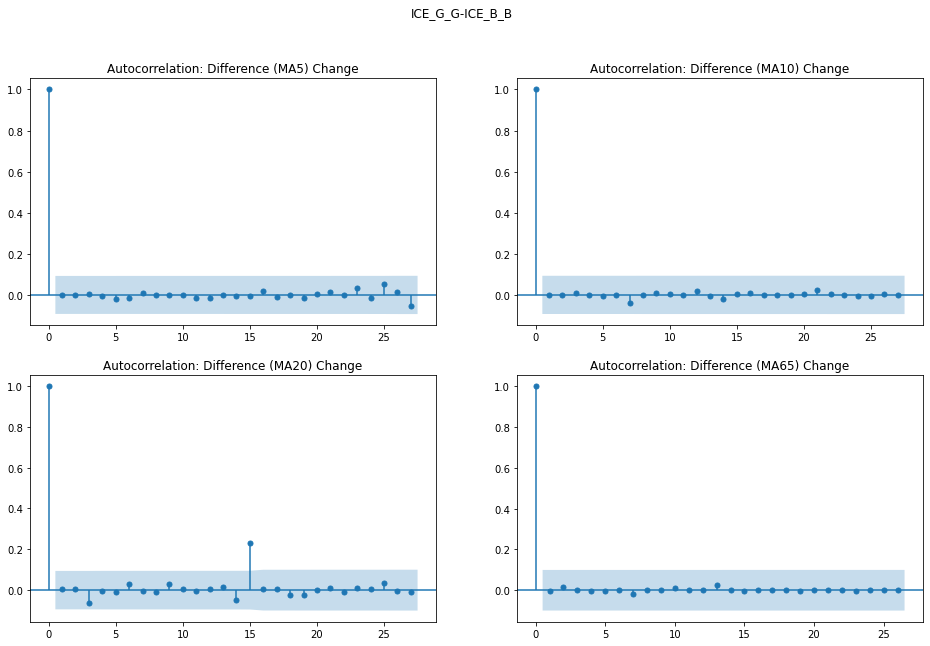

In [19]:
fig, axs = plt.subplots(2,2)
plot_spread = spreads_cols[1]

for i, ma in enumerate(diff_ma.columns.unique(level="LAG")[1:]):
    sm.graphics.tsa.plot_acf(diff_ma[ma][plot_spread].pct_change().dropna(), ax=axs[i//2,i%2])
    axs[i//2,i%2].set_title(f"Autocorrelation: Difference ({ma}) Change")

plt.suptitle(plot_spread)
plt.show()

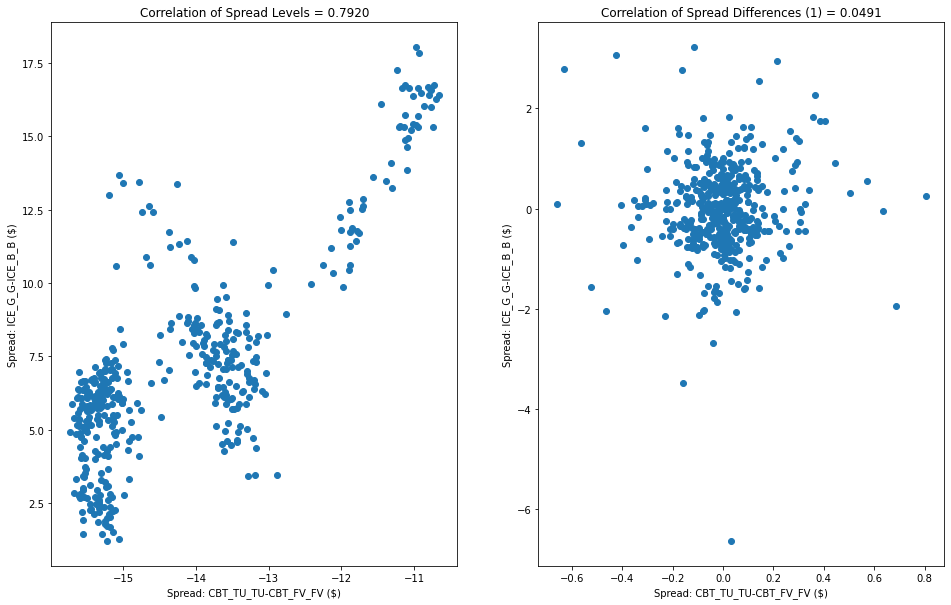

In [20]:
fig, axs = plt.subplots(1,2)

axs[0].scatter(spreads[spreads_cols[0]], spreads[spreads_cols[1]])
axs[0].set_title(f"Correlation of Spread Levels = {spreads.corr().values[0,1]:.4f}")
axs[0].set_xlabel(f"Spread: {spreads_cols[0]} ($)")
axs[0].set_ylabel(f"Spread: {spreads_cols[1]} ($)")

axs[1].scatter(spreads[spreads_cols[0]].diff(), spreads[spreads_cols[1]].diff())
axs[1].set_title(f"Correlation of Spread Differences (1) = {spreads.diff().corr().values[0,1]:.4f}")
axs[1].set_xlabel(f"Spread: {spreads_cols[0]} ($)")
axs[1].set_ylabel(f"Spread: {spreads_cols[1]} ($)")

plt.show()

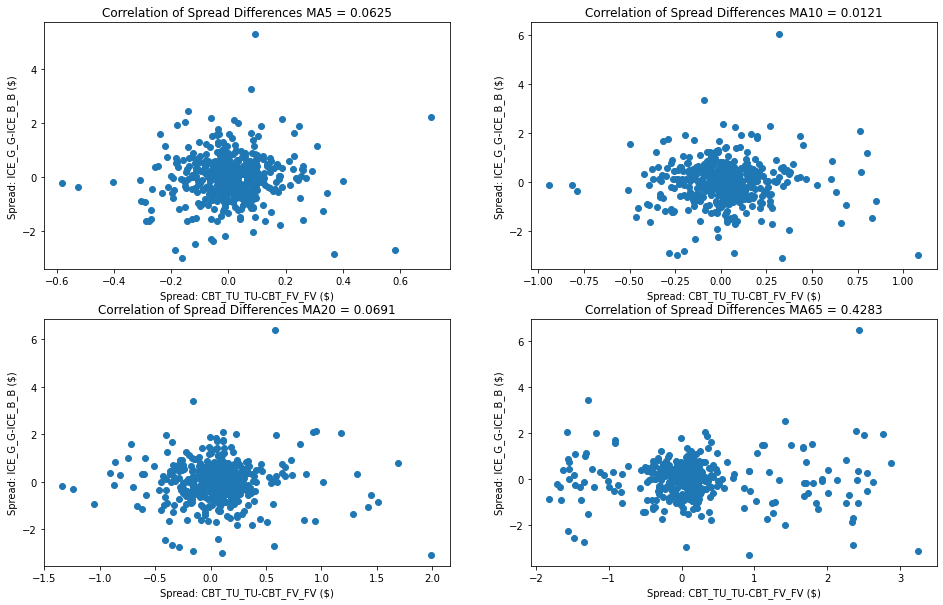

In [21]:
fig, axs = plt.subplots(2,2)

for i, ma in enumerate(diff_ma.columns.unique(level="LAG")[1:]):
    axs[i//2,i%2].scatter(diff_ma[ma][spreads_cols[0]], diff_ma[ma][spreads_cols[1]].diff())
    axs[i//2,i%2].set_title(f"Correlation of Spread Differences {ma} = {diff_ma[ma].corr().values[0,1]:.4f}")
    axs[i//2,i%2].set_xlabel(f"Spread: {spreads_cols[0]} ($)")
    axs[i//2,i%2].set_ylabel(f"Spread: {spreads_cols[1]} ($)")

## Spread Tables

Summary statistics below:

In [22]:
qts = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]

print("Spread Quantiles:")
display(spreads.quantile(qts).append(spreads.describe()))

Spread Quantiles:


,CBT_TU_TU-CBT_FV_FV,ICE_G_G-ICE_B_B
0.0,-15.7328,1.2038
0.1,-15.5312,3.0642
0.2,-15.3875,4.7694
0.3,-15.3016,5.6526
0.4,-15.1797,6.0629
0.5,-14.9188,6.4122
0.6,-13.9984,6.9525
0.7,-13.6131,7.7069
0.8,-13.3619,8.7096
0.9,-11.8797,12.5940


In [23]:
print("Return Quantiles:")
display(changes.quantile(qts).append(changes.describe()))

Return Quantiles:


,CBT_TU_TU-CBT_FV_FV,ICE_G_G-ICE_B_B
0.0,-0.0576,-0.9399
0.1,-0.0108,-0.1582
0.2,-0.0062,-0.0899
0.3,-0.0031,-0.0597
0.4,-0.0011,-0.0385
0.5,0.0001,-0.0011
0.6,0.0022,0.0175
0.7,0.0043,0.0565
0.8,0.0072,0.0997
0.9,0.0124,0.1743


In [24]:
plot_spread = spreads_cols[0]
mas = diff_ma.swaplevel(0,1,1)[plot_spread]
print(f"{plot_spread} MA Quantiles:")
display(mas.quantile(qts).append(mas.describe()))

CBT_TU_TU-CBT_FV_FV MA Quantiles:


LAG,LEVEL,MA5,MA10,MA20,MA65
0.0,-0.6594,-0.5806,-0.9395,-1.3387,-1.8160
0.1,-0.1700,-0.1407,-0.2239,-0.2943,-0.5983
0.2,-0.0969,-0.0713,-0.1196,-0.1618,-0.2690
0.3,-0.0609,-0.0358,-0.0564,-0.0598,-0.1174
0.4,-0.0322,-0.0141,-0.0126,0.0111,0.0013
0.5,-0.0008,0.0022,0.0199,0.0615,0.0960
0.6,0.0172,0.0252,0.0483,0.0962,0.1501
0.7,0.0469,0.0539,0.0932,0.1462,0.2133
0.8,0.0872,0.0852,0.1462,0.2305,0.3618
0.9,0.1534,0.1344,0.2483,0.3637,1.2979


In [25]:
plot_spread = spreads_cols[1]
mas = diff_ma.swaplevel(0,1,1)[plot_spread]
print(f"{plot_spread} MA Quantiles:")
display(mas.quantile(qts).append(mas.describe()))

ICE_G_G-ICE_B_B MA Quantiles:


LAG,LEVEL,MA5,MA10,MA20,MA65
0.0,-6.6362,-2.3721,-3.3069,-4.5878,-3.0166
0.1,-0.8971,-0.6130,-0.9610,-1.2598,-1.8007
0.2,-0.5993,-0.4221,-0.5927,-0.7386,-1.2769
0.3,-0.4204,-0.2585,-0.2932,-0.4885,-0.9537
0.4,-0.2454,-0.0890,-0.0983,-0.2145,-0.6433
0.5,-0.0100,0.0043,0.0239,0.0414,-0.2889
0.6,0.1339,0.1375,0.2163,0.3421,0.1805
0.7,0.3751,0.2663,0.3866,0.5915,1.0892
0.8,0.5875,0.4201,0.6416,0.9712,1.7485
0.9,0.9882,0.6721,1.0034,1.6798,2.7536


# 3.1 Data

Futures pairs W, X; Y, Z (in order) are as given by the last two distinct digits3 of your student number as follows:

The final number, where present, is a multiplier you should apply to X or Z before computing the spreads s.

When downloading from Quandl, you have to use the years and the quarterly codes (H, M, U, Z) individually, there is no facility for Quandl to combine them itself.

Examples of st on various dates that you should be matching in your own data are as follows:

My ID is 12129240 -> CBT_FV_FV (W), CBT_TU_TU (X), ICE_B_B (Y), ICE_G_G/7.45 (Z).